In [1]:
import networkx as nx
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv('df_train.csv')
#df_train["id"] = np.arange(453797)
df_train.head()


,Unnamed: 0,Unnamed: 0.1,node_1,node_2,label,Jaccard,Adamic-Adar,Preferential Attachment,Resource Allocation,Salton Index,Sorensen Index,Common Neighbors,Dispersion,Hub Promoted Index,Hub Depressed Index,Leicht–Holme–Newman Index
0,0,0,10481,5428,1,0.005618,0.192569,7018,0.005556,0.011937,0.011173,1,0.0,0.017241,0.008264,0.479339
1,1,1,7353,30328,0,0.000000,0.000000,36,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000
2,2,2,8627,3547,1,0.005979,0.605220,24130,0.006253,0.025750,0.011887,4,0.0,0.105263,0.006299,0.239370
3,3,3,10232,21925,1,0.000000,0.000000,1368,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000
4,4,4,7110,3288,1,0.000000,0.000000,624,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000


In [4]:
df_train.describe()

,Unnamed: 0,Unnamed: 0.1,node_1,node_2,label,Jaccard,Adamic-Adar,Preferential Attachment,Resource Allocation,Salton Index,Sorensen Index,Common Neighbors,Dispersion,Hub Promoted Index,Hub Depressed Index,Leicht–Holme–Newman Index
count,453797.000000,453797.000000,453797.000000,453797.000000,453797.000000,453797.000000,453797.000000,4.537970e+05,453797.000000,453797.000000,453797.000000,453797.000000,453797.000000,453797.000000,453797.000000,453797.000000
mean,226898.000000,226898.000000,12000.018870,13345.006855,0.625000,0.022059,0.645881,1.732648e+04,0.059265,0.046638,0.037166,2.849318,0.317187,0.113636,0.027808,3.052529
std,131000.054391,131000.054391,9622.056846,9558.693855,0.484124,0.065605,2.523277,1.253437e+05,0.348690,0.101404,0.094638,9.325363,3.006946,0.185247,0.080088,27.387008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113449.000000,113449.000000,3711.000000,4866.000000,0.000000,0.000000,0.000000,7.500000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,226898.000000,226898.000000,8854.000000,11840.000000,1.000000,0.000000,0.000000,6.720000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,340347.000000,340347.000000,19402.000000,21005.000000,1.000000,0.015075,0.456064,5.244000e+03,0.015129,0.048795,0.029703,2.000000,0.000000,0.166667,0.018325,0.529412
max,453796.000000,453796.000000,33225.000000,33225.000000,1.000000,1.000000,217.488901,2.583300e+07,31.989737,1.000000,1.000000,729.000000,331.210894,1.000000,1.000000,6541.583333


#### Evaluation metrics definitions:

In [5]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def evaluate_model(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    precision = precision_score(actual, predictions)
    recall = recall_score(actual, predictions)
    f1 = f1_score(actual, predictions)
    
    metrics = ["accuracy", "precision", "recall", "F1"]
    values = [accuracy, precision, recall, f1]    
    return pd.DataFrame(data={'metric': metrics, 'value': values})

def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

In [6]:
columns = ["Jaccard", "Adamic-Adar", "Preferential Attachment", "Resource Allocation",
           "Common Neighbors","Salton Index","Sorensen Index", "Dispersion", "Hub Promoted Index", "Hub Depressed Index", "Leicht–Holme–Newman Index"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train[columns], df_train["label"], test_size=0.25, random_state=42)


### Random Forest classifier:

We study the f1_scores for several values of the hyperparameters. We have tuned for both **n_estimators** (number of trees in the forest) and for the **max_depth** parameter (max depth of each tree)

In [7]:
from sklearn.ensemble import RandomForestClassifier

f1_train = []
f1_test = []
x = np.arange(5,16)

for i in x:
    clf = RandomForestClassifier(n_estimators=i, max_depth=20, 
                                    random_state=0)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))
    

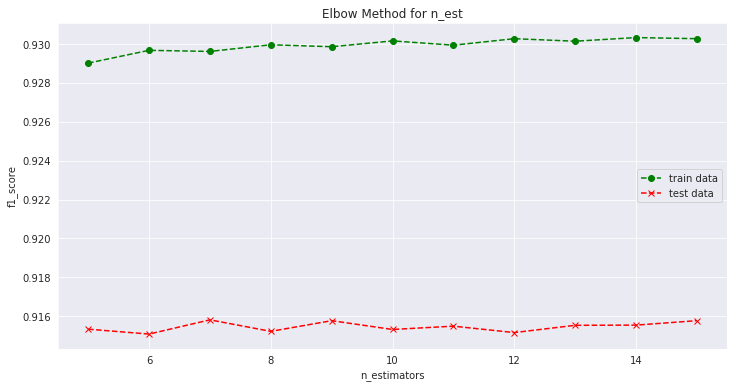

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()



In [9]:
f1_train = []
f1_test = []
x = np.arange(15,26)

for i in x:
    clf = RandomForestClassifier(n_estimators=7, max_depth=i, 
                                    random_state=0)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

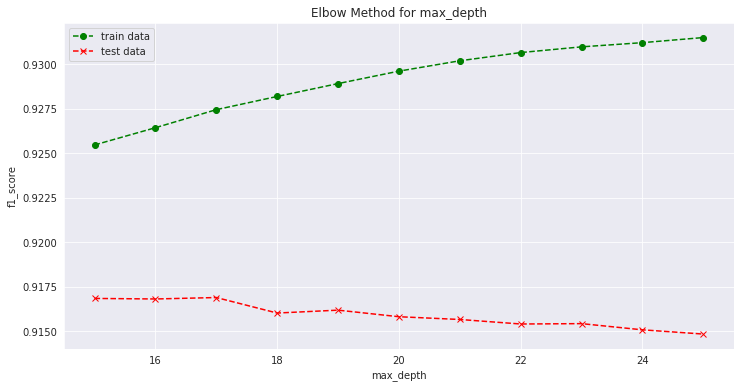

In [10]:
plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("max_depth")
plt.ylabel("f1_score")
plt.title("Elbow Method for max_depth")

plt.legend()

In [11]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=7, max_depth=17, 
                                    random_state=0)


classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [12]:
from sklearn.model_selection import cross_val_score

cv = np.mean(cross_val_score(classifier, X_train, y_train, cv=5))
print("Accuracy using RF with 5 cross validation: {}%".format(round(cv * 100, 2)))

Accuracy using RF with 5 cross validation: 89.67%


In [13]:
predictions = classifier.predict(X_train)

print("Result for training data:")
evaluate_model(predictions, y_train)

Result for training data:


,metric,value
0,accuracy,0.909780
1,precision,0.931950
2,recall,0.923001
3,F1,0.927454


In [14]:
predictions = classifier.predict(X_test)

print("Result for testing data:")
evaluate_model(predictions, y_test)

Result for testing data:


,metric,value
0,accuracy,0.896377
1,precision,0.920102
2,recall,0.913697
3,F1,0.916888


In [15]:
feature_importance(columns, classifier)

,feature,value
0,Preferential Attachment,0.583905
1,Resource Allocation,0.080336
2,Leicht–Holme–Newman Index,0.066808
3,Salton Index,0.061083
4,Sorensen Index,0.058744
5,Adamic-Adar,0.057701
6,Hub Depressed Index,0.056658
7,Common Neighbors,0.013687
8,Jaccard,0.012355
9,Hub Promoted Index,0.008435


### MLP Classifier

In [16]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation = 'logistic',solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(5, 2))
clf.fit(X_train, y_train)

cv = np.mean(cross_val_score(clf, X_train, y_train, cv=5))
print("Accuracy using RF with 5 cross validation: {}%".format(round(cv * 100, 2)))



Accuracy using RF with 5 cross validation: 89.5%


In [17]:
predictions = clf.predict(X_train)

print("Training results: ")
evaluate_model(predictions, y_train)

Training results: 


,metric,value
0,accuracy,0.896670
1,precision,0.916461
2,recall,0.918331
3,F1,0.917395


In [18]:
predictions = clf.predict(X_test)

print("Test results: ")
evaluate_model(predictions, y_test)

Test results: 


,metric,value
0,accuracy,0.895796
1,precision,0.916091
2,recall,0.917459
3,F1,0.916775


### Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

cv = np.mean(cross_val_score(clf, X_train, y_train, cv=5))
print("Accuracy using RF with 5 cross validation: {}%".format(round(cv * 100, 2)))

Accuracy using RF with 5 cross validation: 85.82%


/home/joao/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [44]:
predictions = clf.predict(X_train)

print("Training results: ")
evaluate_model(predictions, y_train)

Training results: 


,metric,value
0,accuracy,0.860554
1,precision,0.960710
2,recall,0.809943
3,F1,0.878908


In [45]:
predictions = clf.predict(X_test)

print("Test results: ")
evaluate_model(predictions, y_test)

Test results: 


,metric,value
0,accuracy,0.861208
1,precision,0.961493
2,recall,0.810599
3,F1,0.879621


### Ada BoostClassifier

In [47]:
from sklearn.ensemble import AdaBoostClassifier

f1_train = []
f1_test = []
x = np.arange(45,56)

for i in x:
    clf = AdaBoostClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

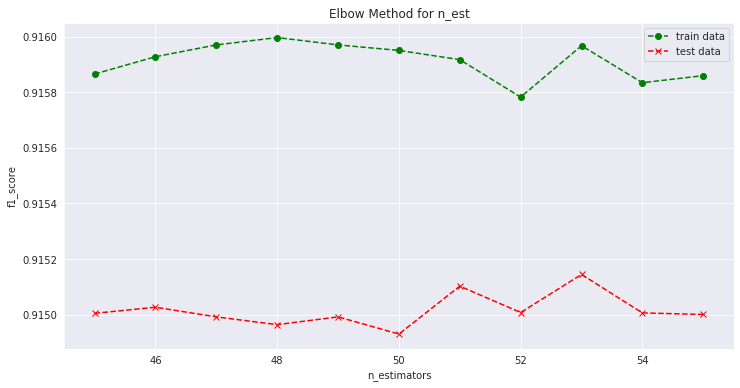

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()



In [29]:
clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores.mean()

0.8939758521069463

In [30]:
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print("Test results: ")
evaluate_model(predictions, y_test)

Test results: 


,metric,value
0,accuracy,0.892534
1,precision,0.906230
2,recall,0.923800
3,F1,0.914930


### GradientBoostingClassifier

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores.mean()

0.8949836460222291

In [32]:
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print("Test results: ")
evaluate_model(predictions, y_test)

Test results: 


,metric,value
0,accuracy,0.894650
1,precision,0.920609
2,recall,0.910076
3,F1,0.915312


### Voting Classifier

In [33]:
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(n_estimators=7, max_depth=16, random_state=0)

clf2 = GradientBoostingClassifier(n_estimators=100, 
                                  learning_rate=1.0,
                                  max_depth=1, random_state=0)
clf3 = MLPClassifier(activation = 'logistic',
                     solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(5, 2))
#('ABC', clf3)

eclf1 = VotingClassifier(estimators=[
    ('RF', clf1), ('mlpC', clf2),("MLP", clf3)], voting='soft', weights=[1,2,1])

eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)

print("Test results: ")
evaluate_model(predictions, y_test)

Test results: 


,metric,value
0,accuracy,0.895602
1,precision,0.920863
2,recall,0.911443
3,F1,0.916128


In [65]:
df_test = pd.read_csv("df_test.csv")


In [64]:
X_test.head()

,Jaccard,Adamic-Adar,Preferential Attachment,Resource Allocation,Common Neighbors,Salton Index,Sorensen Index
415724,0.000000,0.000000,1539,0.000000,0,0.000000,0.000000
67111,0.000000,0.000000,207,0.000000,0,0.000000,0.000000
171707,0.057143,2.826888,5520,0.055786,16,0.215353,0.108108
361790,0.000000,0.000000,12870,0.000000,0,0.000000,0.000000
244716,0.000000,0.000000,364,0.000000,0,0.000000,0.000000


In [67]:
x = df_test[columns]

In [77]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier


clf1 = RandomForestClassifier(n_estimators=7, max_depth=16, random_state=0)

clf2 = GradientBoostingClassifier(n_estimators=100, 
                                  learning_rate=1.0,
                                  max_depth=1, random_state=0)
clf3 = MLPClassifier(activation = 'logistic',
                     solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(5, 2))
#('ABC', clf3)

eclf1 = VotingClassifier(estimators=[
    ('RF', clf1), ('mlpC', clf2),("MLP", clf3)], voting='soft')

eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict(x)

predictions



array([1, 1, 0, ..., 0, 1, 1])

In [78]:
len(predictions)

113450

In [79]:
pred = pd.DataFrame({'id': np.arange(113450), 'predicted': predictions})
pred.head()

,id,predicted
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1


In [80]:
pred.to_csv("predictions.csv", index = False)

In [81]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113450 entries, 0 to 113449
Data columns (total 2 columns):
id           113450 non-null int64
predicted    113450 non-null int64
dtypes: int64(2)
memory usage: 1.7 MB


### Ensemble

from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

evaluate_model(predictions, y_test)

#### Tpot

In [82]:
from tpot import TPOTClassifier

ModuleNotFoundError: No module named 'tpot'

In [11]:
pipeline_optimizer = TPOTClassifier()

In [12]:
pipeline_optimizer = TPOTClassifier(generations=2, population_size=10, cv=3,
                                    verbosity=1)

In [41]:
pipeline_optimizer.fit(X, y)

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.25, min_samples_leaf=14, min_samples_split=15, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=3,
               disable_update_check=False, early_stop=None, generations=2,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=10,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=1, warm_start=False)

In [42]:
print(pipeline_optimizer.score(df_train[columns][-90000:], y[-90000:]))

0.5285111111111112


In [44]:
pred = pipeline_optimizer.predict(df_train[columns][-90000:])

In [45]:
evaluate_model(pred, y[-90000:])

,metric,value
0,accuracy,0.528511
1,precision,0.626405
2,recall,0.614349
3,F1,0.620318


### XGBoost

In [19]:
import xgboost as xgb

In [20]:
data_dmatrix = xgb.DMatrix(data=df_train[columns],label=df_train["label"])

/home/joao/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joao/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [21]:
xg_cl = xgb.XGBClassifier()
xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)
evaluate_model(preds, y_test)

,metric,value
0,accuracy,0.897206
1,precision,0.922351
2,recall,0.912499
3,F1,0.917399


In [13]:
df_test = pd.read_csv("df_test.csv")
x = df_test[columns]
predictions = xg_cl.predict(x)

predictions

array([1, 1, 0, ..., 0, 1, 1])

In [17]:
pred = pd.DataFrame({'id': np.arange(113450), 'predicted': predictions})

pred.to_csv("predictionsXGB.csv", index = False)

### Voting with XGB

In [20]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier



clf1 = RandomForestClassifier(n_estimators=7, max_depth=16, random_state=0)

#clf2 = GradientBoostingClassifier(n_estimators=100, 
                                  #learning_rate=1.0,
                                  #max_depth=1, random_state=0)
clf3 = MLPClassifier(activation = 'logistic',solver='adam', alpha=1e-5,hidden_layer_sizes=(5, 2))

xg_cl = xgb.XGBClassifier()
#('ABC', clf3)

eclf1 = VotingClassifier(estimators=[
    ('RF', clf1), ('XGB', xg_cl),("MLP", clf3)], voting='soft')

eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict(x)

predictions

array([1, 1, 0, ..., 0, 1, 1])

In [21]:
pred = pd.DataFrame({'id': np.arange(113450), 'predicted': predictions})

pred.to_csv("predictionsVoting_XGB.csv", index = False)